In [14]:
import numpy as np
from functools import partial
import pandas as pd
#import matplotlib as mpl
#mpl.rcParams['legend.numpoints'] = 1
import matplotlib.pyplot as plt
%matplotlib inline 
#import mpld3
#mpld3.enable_notebook()

import sys
sys.path.append('../python/')
from EdwRes import *

In [15]:
get_heatRes_func(0.843*2.355, 3.1)
heatRes_GGAl10 = get_heatRes_func(0.4, 3.5)
heatRes_GGAl10_guard = get_heatRes_func(0.655, 4.0)

In [16]:
heatRes_GGAl10(50)

1.4801027369064297

In [10]:
heatRes_data = pd.read_csv("resolution_GeAl10_dataPoints_correctedEnergies.txt", skiprows=1)
print (heatRes_data.head(10))

   Energy    FWHM   error
0  122.10  3.9992  0.4938
1   46.52  1.8558  0.2918
2   10.37  0.6831  0.0757
3    0.00  0.6551  0.0814


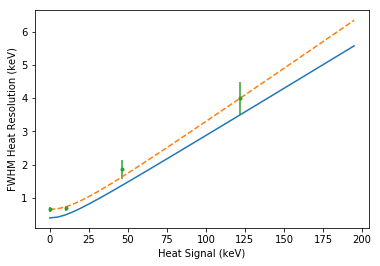

In [11]:
# plot the heat resolution, reproduce fig 2d from 2004 NIMA Edelweiss paper
E_vec = np.arange(0,200,5)
#table, = plt.plot(E_vec, 2.355*heatRes_GGAl10(E_vec), label='Resolution (table)')
#plot, = plt.plot(E_vec, 2.355*heatRes_GGAl10_guard(E_vec), linestyle='--', label='Resolution (plot)')
table, = plt.plot(E_vec, heatRes_GGAl10(E_vec), label='Resolution (table)')
plot, = plt.plot(E_vec, heatRes_GGAl10_guard(E_vec), linestyle='--', label='Resolution (plot)')
data = plt.errorbar((heatRes_data.Energy).tolist(), (heatRes_data.FWHM).tolist(), yerr=(heatRes_data.error).tolist(), fmt='.', label='Guard-event resolution')
plt.xlabel("Heat Signal (keV)")
plt.ylabel("FWHM Heat Resolution (keV)")
#plt.legend(handles=[table, plot, data])
plt.show()

In [17]:
data_GGA3 = pd.read_csv("edelweiss_ER_band_GGA3_curveData.txt", skiprows=1, header=None, delim_whitespace=True)
print (data_GGA3.head(5))
list(data_GGA3.columns.values)

dataNR_GGA3 = pd.read_csv("edelweiss_NR_band_GGA3_curveData.txt", skiprows=1, header=None, delim_whitespace=True)

# expect aH to be 0.020 based on fig. 7
# but my calculations say 0.022?
# increasing heat_0keV decreases the slope btwn 20 and 50 keV
# increasing aH increases the yield in the tail
# increasing ion_122keV even a little increases the yield in the tail
# completely insensitive to heat_122keV
# voltage changes shift curves to the right and increases yield in tail
# increasing ion_center_0keV shifts graph to right, tilts it down: tails become not flat
# increasing ion_guard_0keV has same effect as ion_center_0keV
heat_0keV = 0.4
ion_122keV = 3.1 #3.3 #3.1
V = 4
sig_gamma_GGA3 = get_sig_gamma_func(1.3, 1.5, ion_122keV, heat_0keV, 2.7, V, 0.020)
sig_gamma_GGA3_wide = get_sig_gamma_func(1.3, 1.5, ion_122keV, heat_0keV, 2.7, V, 0.035)

# we'll plot the ER and NR band widths
fig,axes = plt.subplots(1,2,figsize=(17.0,7.0), constrained_layout=True)

# plot the electron recoil widths
E_keV_arr = np.linspace(1,200,100)
ax1 = axes[0]
ax2 = axes[1]
ax1.plot(E_keV_arr, sig_gamma_GGA3(E_keV_arr),'g.')
ax1.plot(E_keV_arr, sig_gamma_GGA3_wide(E_keV_arr),'b.')

#def get_sig_nuc_func(FWHM_center, FWHM_guard, FWHM122_ion, FWHM0_heat, FWHM122_heat, V, aH=None):
# since the resolutions are a function of the electron-equivalent energy, need to convert
# see "edelweiss_energy_scale.pdf" in this directory for explanation:
E_keVee_arr = E_keV_arr*(1+(V/3.0)*Q_avg(E_keV_arr))/(1+(V/3.0)
sig_nr_GGA3 = get_sig_nuc_func(1.3, 1.5, ion_122keV, heat_0keV, 2.7, 4)
ax2.plot(E_keV_arr, sig_nr_GGA3(E_keV_arr*()/()),'g.')

# 90% is +/- 1.645*sigma
# FWHM is 2.355*sigma

# plot the data-theifed bands
ax1.plot(data_GGA3[0], data_GGA3[1], 'r-')
ax1.plot(data_GGA3[2], data_GGA3[3], 'r--')

ax2.plot(dataNR_GGA3[0], dataNR_GGA3[1], 'r-')
ax2.plot(dataNR_GGA3[2], dataNR_GGA3[3], 'r--')
ax2.set_ylim(0,0.1)

ax1.set_ylim(0,0.15)
ax1.minorticks_on()
plt.show()

SyntaxError: invalid syntax (<ipython-input-17-16e6c383b2ac>, line 36)

In [ ]:
# get_sig_gamma_func(FWHM_center, FWHM_guard, FWHM122_ion, FWHM0_heat, FWHM122_heat, V, aH_stretch)
# increasing FWHM0_heat makes the fit better near 20 keV, e.g. from 1.3 to 2.3 for GGA1
# increasing V makes the 20 keV region fit better but makes the high-energy region overshoot the data
# increasing FWHM122_heat increases the width at higher energies and has no impact on lower energies
# increasing aH_stretch increases the width at higher energies and has no impact on lower energies
# if I use the parameters for GeAl6 it seems to fit the bands much better, unless the actual voltage for GeAl6 is used
#sig_gamma_GGA1 = get_sig_gamma_func(1.3, 1.3, 2.8, 1.3, 3.5, 4, 1)
sig_gamma_GGA1 = get_sig_gamma_func(2, 1.4, 2.8, 2.2, 3.5, 6.34, 1.3)
sig_gamma_GGA1_a = get_sig_gamma_func(1.3, 1.3, 2.8, 1.3, 3.5, 4, 1.5)

In [ ]:
band_data = pd.read_csv("edelweiss_bands_GGA1.csv")
print (band_data.head(5))

# path 0: 68.75 keV inelastic scattering
# path 1: average NR line
# path 2: 13.26 keV inelastic
# path 3: ionization threshold
# path 4: lower nuclear recoil band
# path 5: upper nuclear recoil band
# path 6: upper and lower electron recoil band
band_data_svg = pd.read_csv("edelweiss_band_GGA1_curveData.txt", skiprows=1, header=None, delim_whitespace=True)
print (band_data_svg.head(5))
list(band_data_svg.columns.values)

In [ ]:
# 90% is +/- 1.645*sigma
# FWHM is 2.355*sigma

E_keV_arr = np.linspace(1,200,100)

# plot the central nuclear recoil line
plt.plot(band_data_svg[2], band_data_svg[3], 'r', linewidth=1)
#plt.plot(E_keV_arr, Q_avg(E_keV_arr),'r--')

# plot the data-theifed bands
#plt.plot(band_data.x[band_data.x>7.82], band_data.Curve1[band_data.x>7.82], 'b.')
#plt.plot(band_data.x, band_data.curve2, 'b.')
plt.plot(band_data_svg[12][band_data_svg[13]>1], band_data_svg[13][band_data_svg[13]>1], 'b', linewidth=1)
plt.plot(band_data_svg[12][band_data_svg[13]<1], band_data_svg[13][band_data_svg[13]<1], 'b', linewidth=1)

#plt.plot(band_data.x, band_data.curve3, 'r.')
#plt.plot(band_data.x, band_data.curve4, 'r.')
plt.plot(band_data_svg[8], band_data_svg[9], 'r', linewidth=1)
plt.plot(band_data_svg[10], band_data_svg[11], 'r', linewidth=1)

# plot the ionization bands
plt.plot(E_keV_arr, 1+1.645*sig_gamma_GGA1(E_keV_arr), 'c-.', linewidth=2)
plt.plot(E_keV_arr, 1-1.645*sig_gamma_GGA1(E_keV_arr), 'c-')
plt.plot(E_keV_arr, 1+1.645*sig_gamma_GGA1_a(E_keV_arr), 'c--')

plt.ylim(0,1.5)
plt.minorticks_on()
#plt.grid(True)
plt.show()